# 练习 3-3
处理Kaggle上的泰坦尼克数据集

In [1]:
import os
TITANTIC_PATH = os.path.join('./datasets', 'titanic')
TITANTIC_PATH

'./datasets/titanic'

In [2]:
import pandas as pd
def load_titantic_data(filename, titantic_path=TITANTIC_PATH):
    filepath = os.path.join(titantic_path, filename)
    return pd.read_csv(filepath)

In [3]:
# pip install kaggle
# 使用kaggle提供的api下载数据
!kaggle competitions download -c titanic -p datasets

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
train_data = load_titantic_data('train.csv')
test_data = load_titantic_data('test.csv')

In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


可以看出**Age, Cabin, Embarked**数据是不完全的，特别是的Cabin缺失了74%的数据，没办法只能忽略掉Cabin记录了。Age的缺失的数据可以使用median来代替。

而**Name、Ticket**可能有些数字，但是转化为模型可以使用的数字有些棘手，所以也暂时忽略掉相关的记录

In [8]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

- 只有38.34%的人活了下来

In [10]:
train_data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [11]:
train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [12]:
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

创建一个预处理Pipeline

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names]

创建一个pipeline选出数值属性

In [14]:
from sklearn.pipeline import Pipeline
try:
    from sklearn.impute import SimpleImputer # scikit-learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer
num_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
    ("imputer", SimpleImputer(strategy='median'))
])

In [15]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

在0.20以前版本的Scikit-Learn需要使用`LabelBinarizer`或`CategoricalEncoder`才能将分类的值转化为one-hot-vector; 0.20+以上的版本可以直接使用`OneHotEncoder`类

In [16]:
most_ = pd.Series([train_data[c].value_counts().index[0] for c in train_data], index=train_data.columns)
most_

PassengerId                              891
Survived                                   0
Pclass                                     3
Name           Allen, Miss. Elisabeth Walton
Sex                                     male
Age                                       24
SibSp                                      0
Parch                                      0
Ticket                              CA. 2343
Fare                                    8.05
Cabin                                     G6
Embarked                                   S
dtype: object

In [17]:
for c in train_data:
    print(c)

PassengerId
Survived
Pclass
Name
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


In [18]:
train_data['Name'].value_counts().index[0]

'Allen, Miss. Elisabeth Walton'

In [19]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    """
    计算分类中的值出现的次数最多的的类表是多少
    示例：
        如tain_data['Set'].value_counts():
        male      577
        female    314
        Name: Sex, dtype: int64

        则ain_data['Set'].value_counts().index[0]:male
    """
    def fit(self, X, y=None):
        self.most_requent_ = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.most_requent_)

In [20]:
from sklearn.preprocessing import OneHotEncoder


现在创建一个pipeline来处理分类属性

In [21]:
cat_pipeline = Pipeline([
    ('select_cat', DataFrameSelector(['Pclass', 'Sex', 'Embarked'])),
    ('imputer', MostFrequentImputer()),
    ('cat_encoder', OneHotEncoder(sparse=False))
])

In [22]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [ ]:
train_data.head()

**将数字特征和分类特征结合起来**

现在可是使用这个preprocess_pipeline将raw data转化为机器学习模型使用的数据了

In [24]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [25]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

**不要忘了训练的标签数据**

In [26]:
y_train = train_data['Survived']
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

### 首先使用SVC模型测试一下

In [27]:
from sklearn.svm import SVC
svm_clf = SVC(gamma='auto')
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

使用训练好的SVC模型进行预测

In [28]:
X_test = preprocess_pipeline.fit_transform(test_data)
y_pred = svm_clf.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

此时我们可是使用SVC预测的结果按照Kaggle要求的格式构建号CSV文件，上传Kaggle看我们的得分，不过在此之前我们可是使用交叉验证的方法来看看我们的模型表现如何

In [29]:
from sklearn.model_selection import cross_val_score
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores

array([0.66666667, 0.66292135, 0.71910112, 0.74157303, 0.76404494,
       0.71910112, 0.7752809 , 0.73033708, 0.74157303, 0.80898876])

In [30]:
svm_scores.mean()

0.7329588014981274

也就是说模型的accuracy只有73.30%，虽然明显要比随你乱猜要好，但是仍然不是一个好的得分。从kaggle的[leaderboard](https://www.kaggle.com/c/titanic/leaderboard)可以看到前面排名几乎都达到了100%， 不过由于可以下载的到[测试集](https://www.encyclopedia-titanica.org/titanic-victims/)，100%的成绩中有比较大的水分，我们无需理会这些

### 试试RandomForestClassifier

In [31]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores


array([0.74444444, 0.79775281, 0.75280899, 0.80898876, 0.88764045,
       0.83146067, 0.83146067, 0.7752809 , 0.85393258, 0.84269663])

In [32]:
forest_scores.mean()

0.8126466916354558

可以看到RandomForestClassifier明显好了一下

### 试试AdaBoostClassifier

In [33]:
from sklearn.ensemble import AdaBoostClassifier
boost_clf = AdaBoostClassifier(n_estimators=100, random_state=42)
boost_scores = cross_val_score(boost_clf, X_train, y_train, cv=10)
boost_scores.mean()

0.812621722846442

### 试试KNeighborsClassifier

In [34]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=10)
knn_scores.mean()

0.7172659176029963

可以看到`RandomForestClassifier`表现的还是不错的，我们来找一下随机森林的最佳参数

In [35]:
from sklearn.model_selection import GridSearchCV
params_grid = [{
    'n_estimators':[10,20,30, 40, 50],
    'criterion':['gini','entropy'],
    'max_features':['sqrt','log2']}]
grid_search = GridSearchCV(forest_clf, params_grid, cv=5, verbose=3, n_jobs=-1)



In [36]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_features': ['sqrt', 'log2'],
                          'n_estimators': [10, 20, 30, 40, 50]}],
             verbose=3)

In [37]:
grid_search.best_params_

{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 50}

In [39]:
forest_clf = RandomForestClassifier(**grid_search.best_params_)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8182397003745316

### 实时BaggingClassifier

In [46]:
from sklearn.ensemble import BaggingClassifier
bagging_clf = BaggingClassifier(forest_clf)
bagging_clf_acc_sorces = cross_val_score(bagging_clf, X_train, y_train, cv=10, scoring='accuracy')
bagging_clf_f1_sorces = cross_val_score(bagging_clf, X_train, y_train, cv=10, scoring='f1')
bagging_clf_acc_sorces.mean(), bagging_clf_f1_sorces.mean()

(0.8272034956304619, 0.7498901958778095)

In [47]:
bagging_grid_params=[{
    'base_estimator':[svm_clf, forest_clf],
    'n_estimators':[10,20,30, 40, 50],
    'max_samples':[0.1, 0.3, 0.5, 0.8, 1.0],
    'max_features':[0.1, 0.3, 0.5, 0.8, 1.0]
}]
bagging_grid_search = GridSearchCV(bagging_clf, bagging_grid_params, cv=5, verbose=3, n_jobs=-1)

In [ ]:
bagging_grid_search.fit(X_train, y_train)

这里我们不关注每个模型的10折叠的平均分，而是看一下每个模型的每次折叠的箱线图

In [42]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

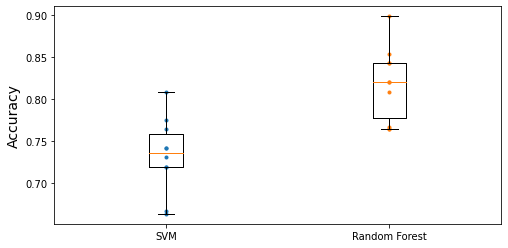

In [43]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, '.')
plt.plot([2]*10, forest_scores, '.')
plt.boxplot([svm_scores, forest_scores], labels=('SVM', 'Random Forest'))
plt.ylabel('Accuracy', fontsize=14)
plt.show()

为了进一步改善结果，可以进行如下操作:
- 对更多模型，使用cross validation和grid search调整超参数
- 使用更多的特征工程,例如:
    - 是**SibSp**和**Parch**的和代替他们
    - 尝试找出与**Survived**属性很好相关的部分
- 尝试把年龄属性更改为年龄段属性


In [44]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [77]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000
